Let's train SEAE with Fast.ai

In [2]:
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from data import SpeechDataset
import time
from wavenetish_model import Wavenetish
from transformer import Transformer
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio
from fastai.vision import *
import numpy as np

In [3]:
EXPLORE = True

In [4]:
batch_size = 1024
num_epochs = 150
learning_rate = 2e-3
window_size = 8192

In [5]:
dataset = SpeechDataset(clean_dir='data/clean/360/',
                        noise_dir='data/noise/', 
                        window_size=window_size, 
                        overlap=50,
                        snr=5,
                        output_one=True,
                        window_step=1,
                        )

In [16]:
dataset_size = len(dataset)
if EXPLORE:
    dataset_size = batch_size * 3
indices = list(range(dataset_size))
validation_split = 0
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [17]:
model = Wavenetish(bs=batch_size).cuda()

In [18]:
def CCE(x, y):
    return nn.CrossEntropyLoss()(x, y.squeeze(1))

In [19]:
data = DataBunch(train_loader, validation_loader)
learner = Learner(data, model, loss_func=CCE, callback_fns=ShowGraph)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,time
0,5.540728,#na#,00:08


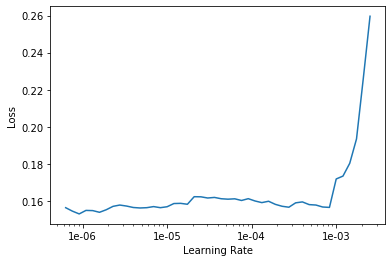

In [20]:
learner.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.171922,22.029791,00:08
1,0.165012,21.925653,00:08
2,0.162744,21.947569,00:08
3,0.158534,21.991140,00:08
4,0.156950,21.953648,00:08
5,0.155100,21.915493,00:08
6,0.157558,21.989136,00:08
7,0.157648,22.114113,00:08
8,0.157156,22.034668,00:08
9,0.157298,21.993824,00:08


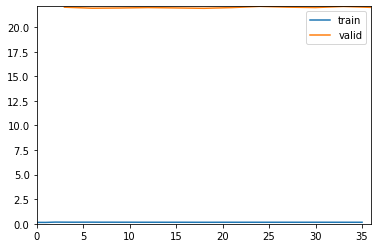

In [22]:
learner.fit_one_cycle(50 , 2e-3)

In [23]:
torch.save(model.state_dict(), f'models/overfit_wvn.pth')

RESULTS

In [24]:
clean_file = 'data/clean/360/2156-82458-0026.wav'
noise_file = 'data/noise/219164.wav'

In [25]:
import math
snr = 5
noise_wave = torchaudio.load(noise_file)[0]
clean_wave = torchaudio.load(clean_file)[0]

noise_len = len(noise_wave[0, :])
clean_len = len(clean_wave[0, :])

if noise_len < clean_len:
    repeat_times = math.ceil(clean_len / noise_len)
    noise_wave = noise_wave.repeat((1, repeat_times))

noised_wave = torch.add(clean_wave[0, :], noise_wave[0, :clean_len] / snr).reshape(1, -1)

In [27]:
from utils import windows

with torch.no_grad():
    model.eval()

    noise_inputs = windows(noised_wave, window_size, 50, step=1)

    predicts = []

    num_batches = (len(noised_wave[0]) // batch_size) - 40
    print(f'batches: {num_batches}')
    for i in range(0, num_batches):
        sample = noise_inputs[0, i * batch_size:((i + 1)*batch_size)]
        reshaped = sample.reshape(-1, 1, window_size).cuda()
        outputs = model(reshaped).detach().cpu()
        if i % 20 == 0: print(f'batch: {i}')
        for output in outputs:
            predicts.append(torch.argmax(output))

batches: 202
batch: 0
batch: 20
batch: 40
batch: 60
batch: 80
batch: 100
batch: 120
batch: 140
batch: 160
batch: 180
batch: 200


In [30]:
decoded = torchaudio.transforms.MuLawDecoding()(torch.tensor(predicts))

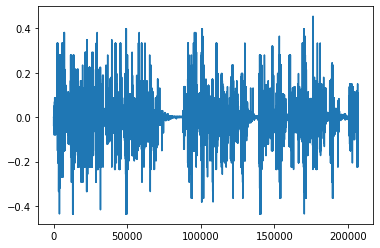

In [32]:
plt.plot(decoded)

In [33]:
Audio(decoded, rate=16000)

#### Let's hear how the model denoises

In [ ]:
from pypesq import pesq

In [ ]:
pesqs = []

data = dataset[0]
model.eval()
with torch.no_grad():
    sample = data[0].cuda()
    output = model(data[0].reshape(-1, 1, 16384).cuda())
    ref = output[0, :, :].cpu().detach().numpy().T[:, 0]
    target = data[1][0, :].cpu().detach().numpy().T[:]
    
    plt.figure()
    plt.plot(ref)
    plt.figure()
    plt.plot(target)

    pesqs.append(pesq(target, ref, 16000))
        
print(round(sum(pesqs) / len(pesqs), 4))
# Change between ref/target to hear model output/original
Audio(ref, rate=16000)

In [ ]:
src = dataset[0][0].reshape(1,1, 16384)
encoder_layer = nn.TransformerEncoderLayer(d_model=16384, nhead=4)
#src = torch.rand(10, 32, 512)
out = encoder_layer(src)
print(out.shape)